# Data Science 1 '22/'23

## Numerical Analysis & Signal Analysis - Interpolation

The following material is covered in Chapter 3 - *Interpolation and Curve Fitting* of the book *Numerical methods in engineering with Python 3* by Jaan Kiusalaas.

<img src="https://m.media-amazon.com/images/I/51uvB6TEd5L.jpg" alt="Book cover" height="10%" width="10%" halign="center" />

### Introduction

Discrete data sets involving a signal $y$ that is measured at positions $x$ are commonly involved in technical calculations. The source of the data may be experimental observations or numerical computations. Various methods exist that attempt to reconstruct the signal at intermediate points where it wasn't actually measured.

There is an important distinction between interpolation and curve fitting methods.

* In [interpolation](https://en.wikipedia.org/wiki/Interpolation) we construct a curve that passes exactly through all the data points. In doing so, we make the implicit assumption that the data points are accurate and distinct.

* In contrast, [curve fitting](https://en.wikipedia.org/wiki/Curve_fitting) is applied to data that contain scatter (noise), usually caused by measurement errors. Then we want to find a smooth curve that approximates the data in some sense. Thus the curve does not necessarily hit the data points.

In this lesson we will focus on interpolation by fitting an interpolant function through a collection of data points. In a next lesson we will look at curve fitting.

### Lagrange's Method

The simplest form of an interpolant is a [polynomial](https://en.wikipedia.org/wiki/Polynomial). It is always possible to construct a unique polynomial of degree $n$ that passes through $n+1$ distinct data points (for example, a line through two points, a parabola through three points, etc.). One means of obtaining this polynomial is the formula of [Lagrange](https://en.wikipedia.org/wiki/Lagrange_polynomial),

$$
P_n(x) = \sum_{i=0}^n y_i \cdot l_i(x)
$$

where the subscript $n$ denotes the degree of the polynomial. The *cardinal functions* $l_i(x)$ are polynomials of degree $n$ that are designed with the special property that

$$
l_i(x_j) = \left\{ \begin{array}{c}
0\text{ if }i\neq j\\
1\text{ if }i=j
\end{array}\right.
$$

That is, they contribute only to the $y$-value of one data point and are equal to zero for all other data points. They can be defined as

$$
\begin{aligned}
l_i(x) &= \frac{x-x_0}{x_i-x_0} \cdot \frac{x-x_1}{x_i-x_1} \cdots \frac{x-x_{i-1}}{x_i-x_{i-1}} \cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdots \frac{x-x_n}{x_i-x_n}
\\
&= \prod_{i \neq j} \frac{x-x_j}{x_i-x_j}
\end{aligned}
$$

Check for yourself that this expression results in $l_i(x_i) = 1$, and $l_i(x_j) = 0$ for any $i \neq j$.

**Example**

To find the equation of the quadratic polynomial that passes through the points $(0,-2)$, $(1,2)$, and $(3,4)$, we first determine the cardinal functions:

* $l_0(x) = \frac{(x-1)(x-3)}{(0-1)(0-3)} = \frac{x^2-4x+3}{3} = \frac{1}{3}x^2-\frac{4}{3}x+1$

* $l_1(x) = \frac{(x-0)(x-3)}{(1-0)(1-3)} = \frac{x^2-3x}{-2} = -\frac{1}{2}x^2+\frac{3}{2}x$

* $l_2(x) = \frac{(x-0)(x-1)}{(3-0)(3-1)} = \frac{x^2-x}{6} = \frac{1}{6}x^3-\frac{1}{6}x$

Now, the desired polynomial equals $\sum_{i=0}^2 y_i \cdot l_i(x)$ which evaluates to

$$
y(x) = -2 \left( \tfrac{1}{3}x^2-\tfrac{4}{3}x+1 \right) + 2 \left( -\tfrac{1}{2}x^2+\tfrac{3}{2}x \right) + 4 \left( \tfrac{1}{6}x^3-\tfrac{1}{6}x \right) = -x^2+5x-2
$$

Check that all four points satisfy this equation.

**Exercise 1**

Write a function `lagrange()` that interpolates between a number of given data points that are specified in lists `xdata` and `ydata`, and calculates the $y$-value that corresponds with the $x$-value that is requested in an argument `x` using Lagrange's method.

In [1]:
def lagrange(x, xdata, ydata):
    """y = lagrange(x, xdata, ydata).
    Lagrange's interpolation method that interpolates a
    polynomial through data {xdata,ydata}, evaluated at x.
    """
    n = len(xdata)
    if len(ydata) != n:
        raise ValueError('Data of unequal length')
    y = 0
    for i in range(n):
        cardinal = getCardinal(i, xdata, x)
        y += ydata[i]*cardinal
    return y

def getCardinal(i, xdata, x):
    above, under = 1, 1
    for j in range(0, len(xdata)):
        if i!=j:
            above *= x - xdata[j]
            under *= xdata[i] - xdata[j]
    return above/under

We apply the method to fit an $n$-th degree polynomial through a series of $n+1$ points with random $y$-values.

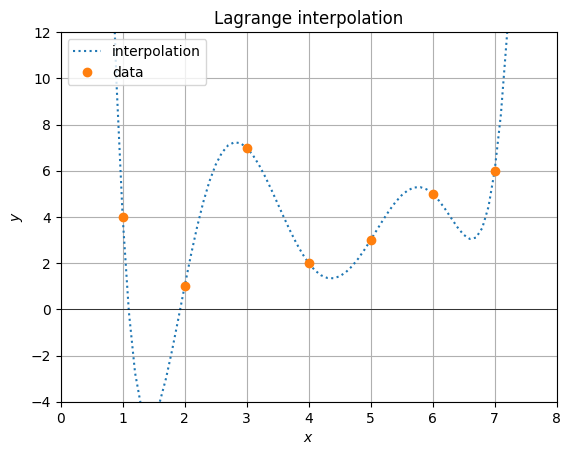

In [4]:
# Example: n-th degree polynomial through n+1 points
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample

xdata = list(range(1, 8))
ydata = sample(xdata, len(xdata))

xs = [i / 10.0 for i in range(5, 76)]
ys = [lagrange(x, xdata, ydata) for x in xs]

plt.plot(xs, ys, ':', label='interpolation')
plt.plot(xdata, ydata, 'o', label='data')
plt.title('Lagrange interpolation'); plt.xlabel('$x$'); plt.ylabel('$y$')
plt.grid(True); plt.axhline(y=0.0, color='k', lw=0.5)
plt.axis((0, 8, -4, 12)); plt.legend(loc='upper left'); plt.show()

### Neville's method

Another computational procedure that fits a polynomial equation through data is obtained with [Neville's algorithm](https://en.wikipedia.org/wiki/Neville%27s_algorithm). This algorithm essentially combines lower-degree polynomials that pass through few data points recursively into higher-degree polynomials that pass through more data points, until a polynomial of sufficient degree is obtained that passes through all data points.

Let $P_{i,j}(x)$ denote the polynomial of degree $j−i$ that passes through the points $(x_k, y_k)$ for $k = i, i+1, \ldots, j$. For a single data point, we have the constant function

$$
P_{i,i}(x) = y_i
$$

To construct the linear function $P_{i,i+1}(x)$ that passes through two points $(x_i,y_i)$ and $x_{i+1},y_{i+1})$, we interpolate between the functions $P_{i,i}(x)$ and $P_{i+1,i+1}(x)$ by forming a weighted average

$$
P_{i,i+1}(x) = w(x) P_{i,i}(x) + \left( 1-w(x) \right) P_{i+1,i+1}(x)
$$

This is achieved by setting $w(x) = \frac{x-x_{i+1}}{x_i-x_{i+1}}$ such that $w(x_i)=1$ and $w(x_{i+1})=0$. The interpolant based on two data points then is

$$
P_{i,i+1}(x) = \frac{(x - x_i) P_{i+1,i+1}(x) - (x−x_{i+1}) P_{i,i}(x)}{x_{i+1}-x_i}
$$

Verify for yourself that $P_{i, i+1}(x)$ passes through the two data points; that is, $P_{i, i+1}(x_i) = y_i$ and $P_{i, i+1}(x_{i+1}) = y_{i+1}$.

For polynomials of higher degree through more than two points, the general recursive formula becomes

$$
P_{i,j}(x) = \frac{(x - x_i) P_{i+1,j}(x) - (x−x_j) P_{i,j-1}(x)}{x_j−x_i}
$$

Given the value of $x$, the computations can be carried out according to the following tableau (shown for four data points):

$$
\begin{array}{llll}
x=x_0: \ P_{0,0}(x)=y_0 & & &
\\
& P_{0,1}(x) & &
\\
x=x_1: \ P_{1,1}(x)=y_1 & & P_{0,2}(x) &
\\
& P_{1,2}(x) & & P_{0,3}(x)
\\
x=x_2: \ P_{2,2}(x)=y_2 & & P_{1,3}(x) &
\\
& P_{2,3}(x) & &
\\
x=x_3: \ P_{3,3}(x)=y_3 & & &
\end{array}
$$

**Example**

Again, for the equation of the quadratic polynomial that passes through the points $(0,-2)$, $(1,2)$, and $(3,4)$, we construct the following tableau.

$$
\begin{array}{llll}
x=0: \ P_{0,0}(x)=-2 & &
\\
& P_{0,1}(x) = \frac{(x-0) \cdot 2 - (x-1) \cdot -2}{1-0} = 4x-2 &
\\
x=1: \ P_{1,1}(x)=2 & & P_{0,2}(x) = \frac{(x-0) \cdot (x+1) - (x-3) \cdot (4x-2)}{3-0} = -x^2+5x-2
\\
& P_{1,2}(x) = \frac{(x-1) \cdot 4 - (x-3) \cdot 2}{3-1} = x+1 &
\\
x=2: \ P_{2,2}(x)=4 & &
\end{array}
$$

Again this results in $y(x) = -x^2+5x-2$.

**Exercise 2**

Write a function `neville()` that interpolates between a number of given data points that are specified in arrays `xdata` and `ydata`, and calculates the $y$-value that corresponds with the $x$-value that is requested in an argument `x` using Neville's method.

In [20]:
import numpy as np   

def neville(x, xdata, ydata):
    xdata = np.array(xdata)
    m = len(xdata)
    y = ydata.copy()
    for k in range(1,m):
        y[0:m-k] = ((x - xdata[k:m])*y[0:m-k] + (xdata[0:m-k] - x)*y[1:m-k+1])/(xdata[0:m-k] - xdata[k:m])
    return y[0]
    

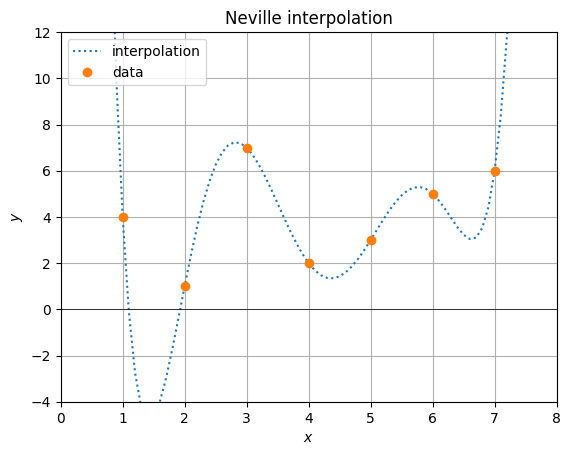

In [21]:
# Example: n-th degree polynomial through n+1 points
ys = [neville(x, xdata, ydata) for x in xs]

plt.plot(xs, ys, ':', label='interpolation')
plt.plot(xdata, ydata, 'o', label='data')
plt.title('Neville interpolation'); plt.xlabel('$x$'); plt.ylabel('$y$')
plt.grid(True); plt.axhline(y=0.0, color='k', lw=0.5)
plt.axis((0, 8, -4, 12)); plt.legend(loc='upper left'); plt.show()

### Cubic spline

If there are more than a few data points, a cubic spline is hard to beat as a global interpolant. A spline is a [piecewise](https://en.wikipedia.org/wiki/Piecewise) polynomial curve: it consists of multiple segments, each of which are polynomials, which are appropriately connected. It is considerably “stiffer” than a polynomial in the sense that it has less tendency to oscillate between data points ([Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon)). The mechanical model of a cubic spline is a thin, elastic beam that is attached with pins to the data points. Because the beam is unloaded between the pins, each segment of the spline curve is a cubic polynomial. The pins (i.e., the data points) are called the *knots* of the spline.

<div class="alert alert-block alert-info">
    
<b>Note:</b> There are many different types of cubic splines, depending on the conditions that are imposed on boundaries and smoothness (see also Exercise 4). Book Chapter 3.3 describes the *natural* cubic spline. Here, we will follow a different approach.

</div>

Let us assume that a sequence of data $(x_i, y_i)$ are provided in sorted order, i.e. $x_0 < x_1 < \ldots < x_n$. Our goal is to interpolate the function at an unknown abcissa $x$. We will assume that $x$ falls in the interval $x_{i-1} < x < x_i$, for some index $i$.

A cubic spline can now be constructed as a *weighted average* of two 2<sup>nd</sup> degree polynomials:

* a parabola $q_{i-1}(x)$ through the left knot and its two direct neighbors, and

* a parabola $q_i(x)$ through the right knot and its two direct neighbors

Both of these parabolas can be evaluated at $x$ using polynomial interpolation (e.g. Lagrange's method or Neville's method).

<div>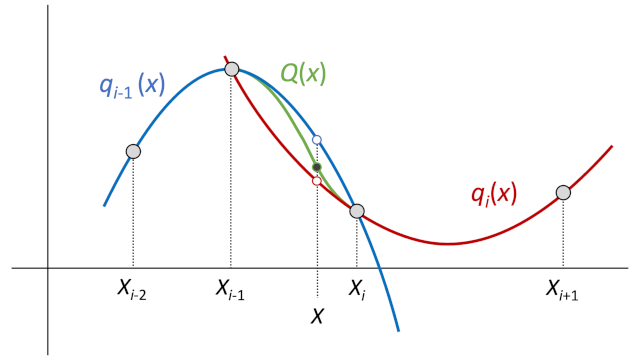</div>

Next, we may combine these results in weighted fashion: near the left knot, the function $q_{i-1}(x)$ is weighted heaviest, whereas near the right knot, the function $q_i(x)$ receives the highest weight. Similar to how polynomials are combined in Nevilles method, we obtain

$$
Q(x) = \frac{(x - x_{i-1}) q_i(x) - (x − x_i) q_{i-1}(x)}{x_i−x_{i-1}}
$$

The result will be a cubic polynomial, regardless of the number of data points $n+1$. However, this is a piece-wise cubic polynomial: each interval $x_{i-1} < x < x_i$ will be assigned a different polynomial. Still, at the knots these will connect smoothly: i.e. their function values and their derivatives are continuous.

Note that if $x$ is near the edge of the range in which measurements were made such that for one of the points $x_{i-1}$ or $x_i$ only one neighbor is available, then a linear function $q_{i-1}(x)$ or $q_i(x)$ can be interpolated through the knot and its single neighbor.

**Exercise 3**

Write a function `cubicspline()` that interpolates between a number of given data points that are specified in arrays `xdata` and `ydata`, and calculates the $y$-value that corresponds with the $x$-value that is requested in an argument `x` using the cubic spline method described above. Find some reasonable solution to deal with the issue that $x$ might fall in the first or last interval, or outside the available range of data.

In [24]:
def cubicspline(x, xdata, ydata):
    """y = cubic_spline(x, xdata, ydata).
    Cubic spline interpolation method that interpolates
    a piecewise 3rd-degree polynomial through data
    {xdata,ydata}, evaluated at x.
    """
    n = len(xdata)
    if len(ydata) != n:
        raise ValueError('Data of unequal length')
    xdata, ydata = zip(*sorted(zip(xdata, ydata)))
    i = 0
    while i <n and x > xdata[i]:
        i+=1
    if i == -1:
        i = 0
    if i == n:
        i = n-1 
    left = lagrange(x, xdata[max(i-2,0):min(i+1,n)], ydata[max(i-2,0):min(i+1,n)])
    right = lagrange(x, xdata[max(i-1,0):min(i+2,n)], ydata[max(i-1,0):min(i+2,n)])
    y = ((x-xdata[i-1])*right-(x-xdata[i])*left)/(xdata[i]-xdata[i-1])
    return y

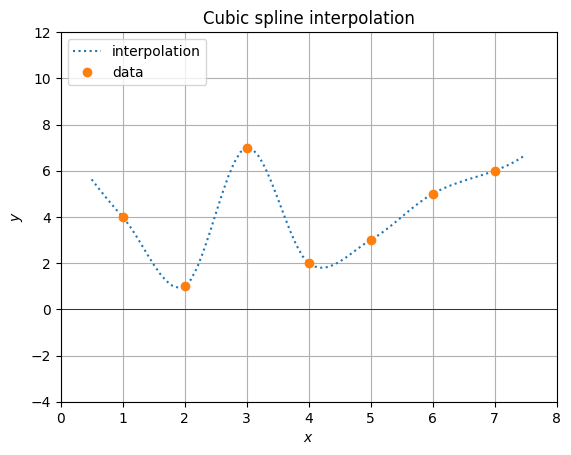

In [25]:
# Example: n-th degree polynomial through n+1 points
ys = [cubicspline(x, xdata, ydata) for x in xs]

plt.plot(xs, ys, ':', label='interpolation')
plt.plot(xdata, ydata, 'o', label='data')
plt.title('Cubic spline interpolation'); plt.xlabel('$x$'); plt.ylabel('$y$')
plt.grid(True); plt.axhline(y=0.0, color='k', lw=0.5)
plt.axis((0, 8, -4, 12)); plt.legend(loc='upper left'); plt.show()

### Exercises

**Exercise 4**

The [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html) module contains various callable functions and classes that perform spline interpolation. Briefly study the documentation and apply the following cubic spline interpolators to the previous example data involving an $n$-th degree polynomial through $n+1$ points.

* `CubicSpline(bc_type='not-a-knot')`

* `CubicSpline(bc_type='clamped')`

* `CubicSpline(bc_type='natural')`

* `PchipInterpolator(extrapolate=True)`

* `Akima1DInterpolator()`

**Exercise 5**

The [population of the Netherlands](https://en.wikipedia.org/wiki/Demography_of_the_Netherlands#Vital_statistics) equalled 10.1 million in the year 1950, 14.1 million in 1980, and 16.6 million in the year 2010. Plot the interpolated population growth from 1950 to the present year including a trendline using applicable functions you wrote in this lesson.

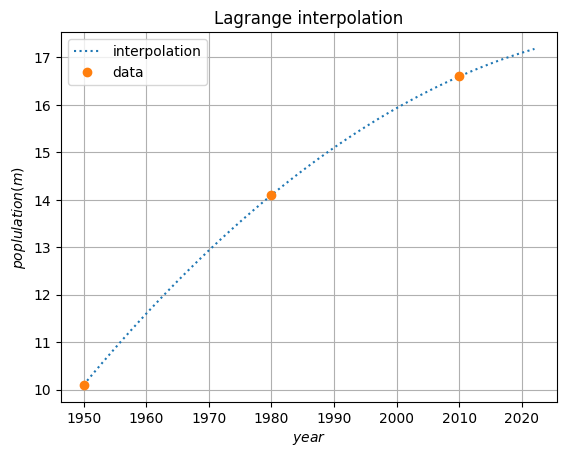

In [29]:
x = [1950, 1980, 2010]
y = [10.1, 14.1, 16.6]

# Example: n-th degree polynomial through n+1 points
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample

xdata = list(x)
ydata = y

xs = [i for i in range(1950, 2023)]
ys = [lagrange(x, xdata, ydata) for x in xs]

plt.plot(xs, ys, ':', label='interpolation')
plt.plot(xdata, ydata, 'o', label='data')
plt.title('Lagrange interpolation'); plt.xlabel('$year$'); plt.ylabel('$poplulation (m)$')
plt.grid(True); 
plt.legend(loc='upper left');
plt.show()


**Exercise 6**

Calculate the value of $y(x) = e^{-x}$ for $x \in \{1, 2, 3, 4\}$. Plot these data points together with their polynomial interpolation between $x = 0$ to $x = 5$. Does the interpolation deviate from the theoretical curve? Also, compare the results of your own function with those from the predefined Lagrange interpolation function that is provided by [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html); read the documentation to figure out how this should be used.

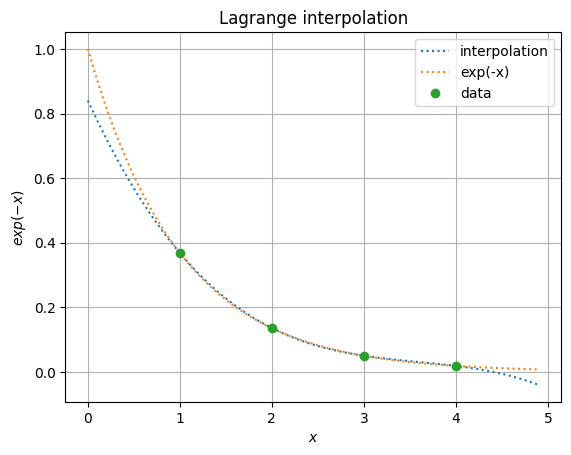

In [35]:
from math import exp
xdata = [1,2,3,4]
ydata = []
for x in xdata:
    ydata.append(exp(-x))

# Example: n-th degree polynomial through n+1 points
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample

xs = [i/10 for i in range(0, 50)]
ys = [lagrange(x, xdata, ydata) for x in xs]

plt.plot(xs, ys, ':', label='interpolation')
plt.plot(xs, [exp(-x) for x in xs], ':', label='exp(-x)')
plt.plot(xdata, ydata, 'o', label='data')
plt.title('Lagrange interpolation'); plt.xlabel('$x$'); plt.ylabel('$exp(-x)$')
plt.grid(True); 
plt.legend(loc='upper right');
plt.show()


**Exercise 7**

We define a function $P(n)$ as the sum of consecutive cubes

$$
P(n) = \sum_{k=0}^n k^3 = 0 + 1 + 8 + 27 + \ldots + n^3
$$

leading to the following [sequence](http://oeis.org/A000537)

| $n$    | 0   | 1   | 2   | 3   | 4   | 5   | 6   | ... |
| ------ | --- | --- | --- | --- | --- | --- | --- | --- |
| $P(n)$ | 0   | 1   | 9   | 36  | 100 | 225 | 441 | ... |

Fit a polynomial as well as a cubic spline to the data in the above table, except for the point $(3, 36)$. Interpolate the value for $n = 3$; also, extrapolate the value for $n = 7$. How well do your answers agree with the exact values $P(3) = 36$ and $P(7) = 784$?

Bonus challenge: can you explain why one of these methods results in correct answers for *any* $n$?

**Exercise 8**

Below you find the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

Fit a polynomial and a cubic spline through these data, and verify that the obtained model function predicts the correct temperatures for each month. Which is a good method to estimate the temperature halfway between January and February though? Or halfway between June and July?

***